# Landing vehicle

<img src="https://mostaqbal.ae/wp-content/uploads/2019/07/india-launching-moon-mission-sunday-1200x630.jpg" alt="Drawing" style="height: 200px;"/>


In [ ]:
from __future__ import print_function
from abc import ABCMeta, abstractmethod
class environment:
 # RLGlue environment


    __metaclass__ = ABCMeta

    def __init__(self):
        reward = None
        observation = None
        termination = None
        self.reward_obs_term = (reward, observation, termination)

    @abstractmethod
    def env_init(self, env_info={}):


    @abstractmethod
    def env_start(self):

    @abstractmethod
    def env_step(self, action):
    
    @abstractmethod
    def env_cleanup(self):

    @abstractmethod
    def env_message(self, message):

class BaseAgent:

    __metaclass__ = ABCMeta

    def __init__(self):
        pass

    @abstractmethod
    def agent_init(self, agent_info= {}):

    @abstractmethod
    def agent_start(self, observation):
 
    @abstractmethod
    def agent_step(self, reward, observation):
      
    @abstractmethod
    def agent_end(self, reward):

    @abstractmethod
    def agent_cleanup(self):

    @abstractmethod
    def agent_message(self, message):

In [ ]:
from __future__ import print_function

#http://www.jmlr.org/papers/v10/tanner09a.html
class RLGlue:


    def __init__(self, env_class, agent_class):
        self.environment = env_class()
        self.agent = agent_class()

        self.total_reward = None
        self.last_action = None
        self.num_steps = None
        self.num_episodes = None

    def rl_init(self, agent_init_info={}, env_init_info={}):
        self.environment.env_init(env_init_info)
        self.agent.agent_init(agent_init_info)

        self.total_reward = 0.0
        self.num_steps = 0
        self.num_episodes = 0

    def rl_start(self, agent_start_info={}, env_start_info={}):
       
        
        self.total_reward = 0.0
        self.num_steps = 1

        last_state = self.environment.env_start()
        self.last_action = self.agent.agent_start(last_state)

        observation = (last_state, self.last_action)

        return observation

    def rl_agent_start(self, observation):

        return self.agent.agent_start(observation)

    def rl_agent_step(self, reward, observation):
       
        return self.agent.agent_step(reward, observation)

    def rl_agent_end(self, reward):

        self.agent.agent_end(reward)

    def rl_env_start(self):
 
        self.total_reward = 0.0
        self.num_steps = 1

        this_observation = self.environment.env_start()

        return this_observation

    def rl_env_step(self, action):

        ro = self.environment.env_step(action)
        (this_reward, _, terminal) = ro

        self.total_reward += this_reward

        if terminal:
            self.num_episodes += 1
        else:
            self.num_steps += 1

        return ro

    def rl_step(self):

        (reward, last_state, term) = self.environment.env_step(self.last_action)

        self.total_reward += reward;

        if term:
            self.num_episodes += 1
            self.agent.agent_end(reward)
            roat = (reward, last_state, None, term)
        else:
            self.num_steps += 1
            self.last_action = self.agent.agent_step(reward, last_state)
            roat = (reward, last_state, self.last_action, term)

        return roat

    def rl_cleanup(self):
        self.environment.env_cleanup()
        self.agent.agent_cleanup()

    def rl_agent_message(self, message):
       

        return self.agent.agent_message(message)

    def rl_env_message(self, message):

        return self.environment.env_message(message)

    def rl_episode(self, max_steps_this_episode):

        is_terminal = False

        self.rl_start()

        while (not is_terminal) and ((max_steps_this_episode == 0) or
                                     (self.num_steps < max_steps_this_episode)):
            rl_step_result = self.rl_step()
            is_terminal = rl_step_result[3]

        return is_terminal

    def rl_return(self):
 
        return self.total_reward

    def rl_num_steps(self):

        return self.num_steps

    def rl_num_episodes(self):

        return self.num_episodes


In [ ]:
import numpy as np
import gym

class Landingvehicle(environment):
    def env_init(self, env_info={}):
        
        self.env = gym.make("LunarLander-v2")
        self.env.seed(0)

    def env_start(self):
      
        reward = 0.0
        observation = self.env.reset()
        is_terminal = False
                
        self.reward_obs_term = (reward, observation, is_terminal)
        
        return self.reward_obs_term[1]
        
    def env_step(self, action):
     

        last_state = self.reward_obs_term[1]
        current_state, reward, is_terminal, _ = self.env.step(action)
        
        self.reward_obs_term = (reward, current_state, is_terminal)
        
        return self.reward_obs_term

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

plt_legend_dict = {"expected_sarsa_agent": "Expected SARSA with neural network",
                   "random_agent": "Random"}
path_dict = {"expected_sarsa_agent": "results/",
             "random_agent": "./"}

plt_label_dict = {"expected_sarsa_agent": "Sum of\nreward\nduring\nepisode"}



# Function to plot result
def plot_result(data_name_array):
    plt_agent_sweeps = []
    
    fig, ax = plt.subplots(figsize=(8,6))

    
    for data_name in data_name_array:
        
        # load data
        filename = 'sum_reward_{}'.format(data_name).replace('.','')
        sum_reward_data = np.load('{}/{}.npy'.format(path_dict[data_name], filename))

        # smooth data
        smoothed_sum_reward = smooth(data = sum_reward_data, k = 100)
        
        mean_smoothed_sum_reward = np.mean(smoothed_sum_reward, axis = 0)

        plot_x_range = np.arange(0, mean_smoothed_sum_reward.shape[0])
        graph_current_agent_sum_reward, = ax.plot(plot_x_range, mean_smoothed_sum_reward[:], label=plt_legend_dict[data_name])
        plt_agent_sweeps.append(graph_current_agent_sum_reward)
    
    ax.legend(handles=plt_agent_sweeps, fontsize = 13)
    ax.set_title("Learning Curve", fontsize = 15)
    ax.set_xlabel('Episodes', fontsize = 14)
    ax.set_ylabel(plt_label_dict[data_name_array[0]], rotation=0, labelpad=40, fontsize = 14)
    ax.set_ylim([-300, 300])

    plt.tight_layout()
    plt.show()     

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import deque
from copy import deepcopy
from tqdm import tqdm
import os 
import shutil

## Action-Value Network

In [3]:
class ActionValueNetwork:
    def __init__(self, network_config):
        self.state_dim = network_config.get("state_dim")
        self.num_hidden_units = network_config.get("num_hidden_units")
        self.num_actions = network_config.get("num_actions")
        
        self.rand_generator = np.random.RandomState(network_config.get("seed"))
        self.layer_sizes = [self.state_dim,self.num_hidden_units,self.num_actions ]
        self.weights = [dict() for i in range(0, len(self.layer_sizes) - 1)]
        for i in range(0, len(self.layer_sizes) - 1):
            self.weights[i]['W'] = self.init_saxe(self.layer_sizes[i], self.layer_sizes[i + 1])
            self.weights[i]['b'] = np.zeros((1, self.layer_sizes[i + 1]))
    def get_action_values(self, s):
 
        W0, b0 = self.weights[0]['W'], self.weights[0]['b']
        psi = np.dot(s, W0) + b0
        x = np.maximum(psi, 0)
        
        W1, b1 = self.weights[1]['W'], self.weights[1]['b']
        q_vals = np.dot(x, W1) + b1

        return q_vals
    
    def get_TD_update(self, s, delta_mat):
  

        W0, b0 = self.weights[0]['W'], self.weights[0]['b']
        W1, b1 = self.weights[1]['W'], self.weights[1]['b']
        
        psi = np.dot(s, W0) + b0
        x = np.maximum(psi, 0)
        dx = (psi > 0).astype(float)

      
        td_update = [dict() for i in range(len(self.weights))]
         
        v = delta_mat
        td_update[1]['W'] = np.dot(x.T, v) * 1. / s.shape[0]
        td_update[1]['b'] = np.sum(v, axis=0, keepdims=True) * 1. / s.shape[0]
        
        v = np.dot(v, W1.T) * dx
        td_update[0]['W'] = np.dot(s.T, v) * 1. / s.shape[0]
        td_update[0]['b'] = np.sum(v, axis=0, keepdims=True) * 1. / s.shape[0]
                
        return td_update
    
   
    def init_saxe(self, rows, cols):
     
        tensor = self.rand_generator.normal(0, 1, (rows, cols))
        if rows < cols:
            tensor = tensor.T
        tensor, r = np.linalg.qr(tensor)
        d = np.diag(r, 0)
        ph = np.sign(d)
        tensor *= ph

        if rows < cols:
            tensor = tensor.T
        return tensor
    
    def get_weights(self):
      
        return deepcopy(self.weights)
    
    def set_weights(self, weights):

        self.weights = deepcopy(weights)

##  Adam Optimizer

 
$$\mathbf{m_t} = \beta_m \mathbf{m_{t-1}} + (1 - \beta_m)g_t \\
\mathbf{v_t} = \beta_v \mathbf{v_{t-1}} + (1 - \beta_v)g^2_t
$$

Here, $\beta_m$ and $\beta_v$ are fixed parameters controlling the linear combinations above and $g_t$ is the update at time $t$ (generally the gradients, but here the TD error times the gradients).

Given that $\mathbf{m}$ and $\mathbf{v}$ are initialized to zero, they are biased toward zero. To get unbiased estimates of the mean and second moment, Adam defines $\mathbf{\hat{m}}$ and $\mathbf{\hat{v}}$ as:
$$ \mathbf{\hat{m}_t} = \frac{\mathbf{m_t}}{1 - \beta_m^t} \\
\mathbf{\hat{v}_t} = \frac{\mathbf{v_t}}{1 - \beta_v^t}
$$

The weights are then updated as follows:
$$ \mathbf{w_t} = \mathbf{w_{t-1}} + \frac{\alpha}{\sqrt{\mathbf{\hat{v}_t}}+\epsilon} \mathbf{\hat{m}_t}
$$

Here, $\alpha$ is the step size parameter and $\epsilon$ is another small parameter to keep the denominator from being zero.

 

In [4]:
class Adam():
    def __init__(self, layer_sizes, 
                 optimizer_info):
        self.layer_sizes = layer_sizes

        # Specify Adam algorithm's hyper parameters
        self.step_size = optimizer_info.get("step_size")
        self.beta_m = optimizer_info.get("beta_m")
        self.beta_v = optimizer_info.get("beta_v")
        self.epsilon = optimizer_info.get("epsilon")
        
        # Initialize Adam algorithm's m and v
        self.m = [dict() for i in range(1, len(self.layer_sizes))]
        self.v = [dict() for i in range(1, len(self.layer_sizes))]
        
        for i in range(0, len(self.layer_sizes) - 1):
            self.m[i]["W"] = np.zeros((self.layer_sizes[i],self.layer_sizes[i+1]))
            self.m[i]["b"] = np.zeros( (1,self.layer_sizes[i+1]) )
            self.v[i]["W"] = np.zeros((self.layer_sizes[i],self.layer_sizes[i+1]))
            self.v[i]["b"] = np.zeros( (1,self.layer_sizes[i+1]) )
        self.beta_m_product = self.beta_m
        self.beta_v_product = self.beta_v
    
    def update_weights(self, weights, td_errors_times_gradients):
    
        for i in range(len(weights)):
            for param in weights[i].keys():
                self.m[i][param] = (self.beta_m * self.m[i][param]) + (1-self.beta_m) * td_errors_times_gradients[i][param]
                m_hat = self.m[i][param] / (1-self.beta_m_product)
                self.v[i][param] = (self.beta_v * self.v[i][param]) + (1-self.beta_v)*(td_errors_times_gradients[i][param]**2)
                v_hat = self.v[i][param] / (1-self.beta_v_product)
                weight_update = (self.step_size * m_hat) / (v_hat**0.5 + self.epsilon )            
                weights[i][param] = weights[i][param] + weight_update
        self.beta_m_product *= self.beta_m
        self.beta_v_product *= self.beta_v
        
        return weights

 ## Experience Replay Buffers

In [5]:
class ReplayBuffer:
    def __init__(self, size, minibatch_size, seed):

        self.buffer = []
        self.minibatch_size = minibatch_size
        self.rand_generator = np.random.RandomState(seed)
        self.max_size = size

    def append(self, state, action, reward, terminal, next_state):
  
        if len(self.buffer) == self.max_size:
            del self.buffer[0]
        self.buffer.append([state, action, reward, terminal, next_state])

    def sample(self):
#Returns: A list of transition tuples including state, action, reward, terinal, and next_state
         
        idxs = self.rand_generator.choice(np.arange(len(self.buffer)), size=self.minibatch_size)
        return [self.buffer[idx] for idx in idxs]

    def size(self):
        return len(self.buffer)

##  Softmax Policy


The probability of selecting each action according to the softmax policy is shown below:
$$Pr{(A_t=a | S_t=s)} \hspace{0.1cm} \dot{=} \hspace{0.1cm} \frac{e^{Q(s, a)/\tau}}{\sum_{b \in A}e^{Q(s, b)/\tau}}$$
where $\tau$ is the temperature parameter which controls how much the agent focuses on the highest valued actions.  
 
 In a numerically stable (softmax policy) , using  maximum action-value from the action-values.The probability of selecting each action looks as follows:

$$Pr{(A_t=a | S_t=s)} \hspace{0.1cm} \dot{=} \hspace{0.1cm} \frac{e^{Q(s, a)/\tau - max_{c}Q(s, c)/\tau}}{\sum_{b \in A}e^{Q(s, b)/\tau - max_{c}Q(s, c)/\tau}}$$

 

In [6]:
def softmax(action_values, tau=1.0):
    preferences = action_values / tau
    max_preference = np.max(preferences,axis=1)
    reshaped_max_preference = max_preference.reshape((-1, 1))
    exp_preferences = np.exp(preferences - reshaped_max_preference)
    sum_of_exp_preferences = np.sum(exp_preferences,axis=1)
    reshaped_sum_of_exp_preferences = sum_of_exp_preferences.reshape((-1, 1))
    action_probs = exp_preferences / reshaped_sum_of_exp_preferences
    action_probs = action_probs.squeeze()
    return action_probs


$$
\begin{align}
& Q_t \leftarrow \text{action-value network at timestep t (current action-value network)}\\
& \text{Initialize } Q_{t+1}^1 \leftarrow Q_t\\
& \text{For } i \text{ in } [1, ..., N] \text{ (i.e. N} \text{  replay steps)}:\\
& \hspace{1cm} s, a, r, t, s'
\leftarrow \text{Sample batch of experiences from experience replay buffer} \\
& \hspace{1cm} \text{Do Expected Sarsa update with } Q_t: Q_{t+1}^{i+1}(s, a) \leftarrow Q_{t+1}^{i}(s, a) + \alpha \cdot \left[r + \gamma \left(\sum_{b} \pi(b | s') Q_t(s', b)\right) - Q_{t+1}^{i}(s, a)\right]\\
& \hspace{1.5cm} \text{ making sure to add the } \gamma \left(\sum_{b} \pi(b | s') Q_t(s', b)\right) \text{ for non-terminal transitions only.} \\
& \text{After N replay steps,   set } Q_{t+1}^{N} \text{ as } Q_{t+1} \text{ and have a new } Q_{t+1} \text{for time step } t + 1 \text{ that   will fix in the next set of updates. }
\end{align}
$$

In [7]:
def get_td_error(states, next_states, actions, rewards, discount, terminals, network, current_q, tau):
    q_next_mat = current_q.get_action_values(next_states)
    probs_mat = softmax(q_next_mat,tau)
    v_next_vec = np.sum(q_next_mat * probs_mat,axis=1)*(1-terminals)
    target_vec = rewards + discount*v_next_vec
    q_mat = network.get_action_values(states)
    batch_indices = np.arange(q_mat.shape[0])
    q_vec = q_mat[batch_indices,actions]
    delta_vec = target_vec - q_vec
    
    return delta_vec

In [8]:
 def optimize_network(experiences, discount, optimizer, network, current_q, tau):
 
    states, actions, rewards, terminals, next_states = map(list, zip(*experiences))
    states = np.concatenate(states)
    next_states = np.concatenate(next_states)
    rewards = np.array(rewards)
    terminals = np.array(terminals)
    batch_size = states.shape[0]
    delta_vec = get_td_error(states, next_states, actions, rewards, discount, terminals, network, current_q, tau)
    batch_indices = np.arange(batch_size)
    delta_mat = np.zeros((batch_size, network.num_actions))
    delta_mat[batch_indices, actions] = delta_vec
    td_update = network.get_TD_update(states,delta_mat)
    weights = optimizer.update_weights(network.get_weights(), td_update)

    network.set_weights(weights)

In [9]:
class Agent(BaseAgent):
    def __init__(self):
        self.name = "expected_sarsa_agent"
        
    def agent_init(self, agent_config):
    
        self.replay_buffer = ReplayBuffer(agent_config['replay_buffer_size'], 
                                          agent_config['minibatch_sz'], agent_config.get("seed"))
        self.network = ActionValueNetwork(agent_config['network_config'])
        self.optimizer = Adam(self.network.layer_sizes, agent_config["optimizer_config"])
        self.num_actions = agent_config['network_config']['num_actions']
        self.num_replay = agent_config['num_replay_updates_per_step']
        self.discount = agent_config['gamma']
        self.tau = agent_config['tau']
        
        self.rand_generator = np.random.RandomState(agent_config.get("seed"))
        
        self.last_state = None
        self.last_action = None
        
        self.sum_rewards = 0
        self.episode_steps = 0

    def policy(self, state):
 
        action_values = self.network.get_action_values(state)
        probs_batch = softmax(action_values, self.tau)
        action = self.rand_generator.choice(self.num_actions, p=probs_batch.squeeze())
        return action
    
    def agent_start(self, state):

        self.sum_rewards = 0
        self.episode_steps = 0
        self.last_state = np.array([state])
        self.last_action = self.policy(self.last_state)
        return self.last_action


    def agent_step(self, reward, state):
     
        self.sum_rewards += reward
        self.episode_steps += 1

    
        state = np.array([state])

 
        action = self.policy(state)

        self.replay_buffer.append(self.last_state, self.last_action, reward, 0, state)
    
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
            current_q = deepcopy(self.network)
            for _ in range(self.num_replay):
                experiences = self.replay_buffer.sample()
                optimize_network(experiences,self.discount,self.optimizer,self.network,current_q,self.tau)
        self.last_state = state
        self.last_action = action
        
        return action

    def agent_end(self, reward):

        self.sum_rewards += reward
        self.episode_steps += 1
        state = np.zeros_like(self.last_state)
        self.replay_buffer.append(self.last_state,self.last_action,reward,1,state)
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
            current_q = deepcopy(self.network)
            for _ in range(self.num_replay):
                experiences = self.replay_buffer.sample()
                optimize_network(experiences,self.discount,self.optimizer,self.network,current_q,self.tau)
                
        
    def agent_message(self, message):
        if message == "get_sum_reward":
            return self.sum_rewards
        else:
            raise Exception("Unrecognized Message!")


100%|██████████| 300/300 [11:07<00:00,  2.23s/it]


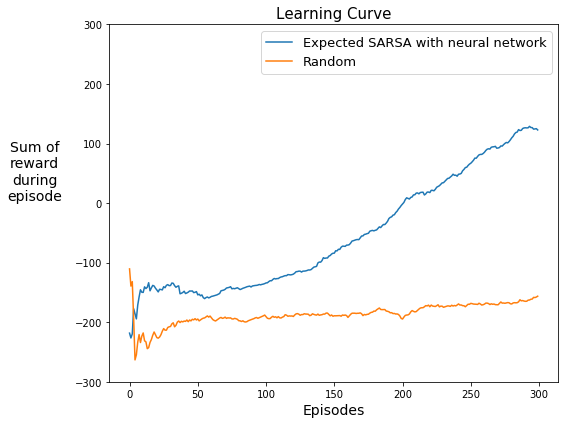

In [11]:
def run_experiment(environment, agent, environment_parameters, agent_parameters, experiment_parameters):
    
    rl_glue = RLGlue(environment, agent)
        
    # save sum of reward at the end of each episode
    agent_sum_reward = np.zeros((experiment_parameters["num_runs"], 
                                 experiment_parameters["num_episodes"]))

    env_info = {}

    agent_info = agent_parameters

    # one agent setting
    for run in range(1, experiment_parameters["num_runs"]+1):
        agent_info["seed"] = run
        agent_info["network_config"]["seed"] = run
        env_info["seed"] = run

        rl_glue.rl_init(agent_info, env_info)
        
        for episode in tqdm(range(1, experiment_parameters["num_episodes"]+1)):
            # run episode
            rl_glue.rl_episode(experiment_parameters["timeout"])
            
            episode_reward = rl_glue.rl_agent_message("get_sum_reward")
            agent_sum_reward[run - 1, episode - 1] = episode_reward
    save_name = "{}".format(rl_glue.agent.name)
    if not os.path.exists('results'):
        os.makedirs('results')
    np.save("results/sum_reward_{}".format(save_name), agent_sum_reward)
    shutil.make_archive('results', 'zip', 'results')

# Run Experiment

# Experiment parameters
experiment_parameters = {
    "num_runs" : 1,
    "num_episodes" : 300,
    # OpenAI Gym environments allow for a timestep limit timeout, causing episodes to end after 
    # some number of timesteps. 
    "timeout" : 1000
}

# Environment parameters
environment_parameters = {}

current_env = Landingvehicle

# Agent parameters
agent_parameters = {
    'network_config': {
        'state_dim': 8,
        'num_hidden_units': 256,
        'num_actions': 4
    },
    'optimizer_config': {
        'step_size': 1e-3,
        'beta_m': 0.9, 
        'beta_v': 0.999,
        'epsilon': 1e-8
    },
    'replay_buffer_size': 50000,
    'minibatch_sz': 8,
    'num_replay_updates_per_step': 4,
    'gamma': 0.99,
    'tau': 0.001
}
current_agent = Agent

# run experiment
run_experiment(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)
plot_result(["expected_sarsa_agent", "random_agent"])

In [12]:
%%HTML
<div align="middle">
<video width="80%" controls>
      <source src="Landingvehicle.mp4" type="video/mp4">
</video></div>